<a href="https://colab.research.google.com/github/rorgt/2024-term-project/blob/main/CoLab_TermProj_GO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GO term enrichment analysis for CLIP and ribosome profiling (Fig 5A)

* Each circle represents a **GO term**.
* The **color intensity** indicates statistical significance of enrichment or depletion determined by **Mann-Whitney U test**.
* The **size of the circle** corresponds to **the number of genes**.
* The **coordinates** indicate average CLIP tag enrichment (x axis) and ribosome density change (y axis). **= TermProj_2024_1**
* Balloons contain the **number of genes** (written in parentheses) and p values for CLIPseq (C) and ribosome footprinting (R).
* *Note that nucleosome-related terms are overestimated artificially in CLIP because of a normalization problem due to the lack of polyA tail in histone mRNAs.*



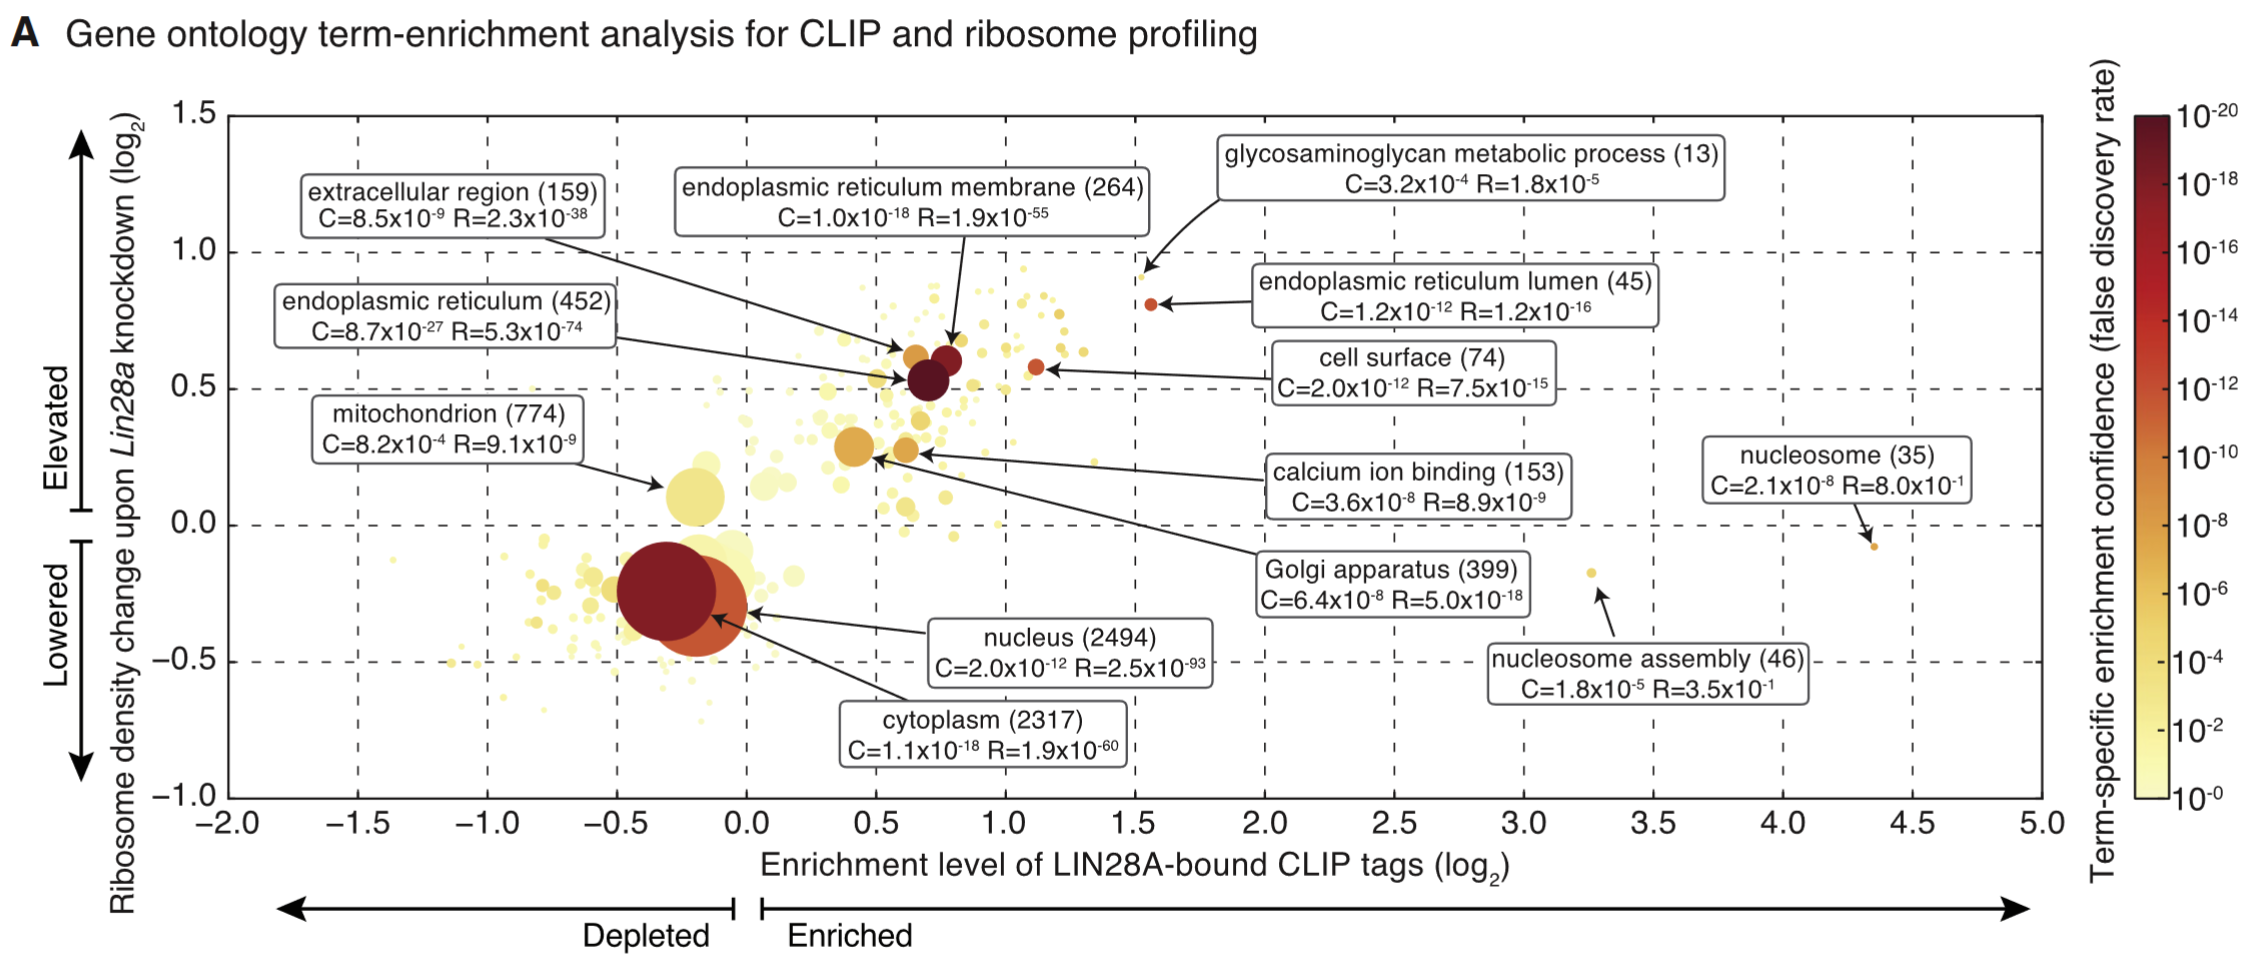

## Transcript count table


* TermProj_2024_1과 동일한 환경 설정, 시퀀싱 데이터 다운로드 과정임.
* 런타임 연결마다 모두 실행하면 됨.


In [1]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 실습용 biconda 환경
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

Cloning into 'colab-biolab'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 76 (delta 26), reused 59 (delta 15), pack-reused 0
Receiving objects: 100% (76/76), 318.16 KiB | 1.29 MiB/s, done.
Resolving deltas: 100% (26/26), done.
./
./root/
./root/.profile
./root/.tmux.conf
./root/.bin.priority/
./root/.bin.priority/pip2
./root/.bin.priority/pip3
./root/.bin.priority/pip
./root/.vimrc
./root/.bashrc.biolab
./root/.condarc
--2024-06-08 14:12:38--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143808873 (137M) [application/octet-stream]
Saving to: ‘miniconda3.sh’

miniconda3.sh       100%[===================>] 137.15M  

In [3]:
# 시퀀싱 데이터 다운로드 (이미 진행하여 생략, 체크섬 생략)
# !ls -al /content/drive/MyDrive/binfo1-datapack1/

In [4]:
# 프로그램 추가 설치 (이미 featurecount 진행하여 생략)
# !conda install -y subread

In [5]:
# 작업 디렉토리 만들고 복사하기 (이미 진행하여 생략)
# !mkdir /content/drive/MyDrive/binfo1-work
# !chmod +777 /content/drive/MyDrive/binfo1-work
# !cp -f /content/drive/MyDrive/binfo1-datapack1/*.* /content/drive/MyDrive/binfo1-work/

In [6]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


In [7]:
# bam (aligned reads), gtf (annotation) -> gene 별 read count (이미 진행하여 생략)
# !featureCounts -a gencode.gtf -o read-counts.txt *.bam

## Gene ID별 GO, 좌표 table

* transcript count table 중 발현이 낮은 값을 제거한 뒤 좌표 값을 계산함.
* GO는 Biomart에서 .tsv로 받았음. (6/6/24 기준 빌드 버전 GRCm39)
* 버전 제거 Gene ID를 기준으로 좌표와 GO를 합친 dataframe을 생성함.

In [8]:
import pandas as pd
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

print(cnts.shape)
cnts.head()

(55359, 13)


,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,CLIP-let7g.bam,filtered-RPF-siLuc.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam
Geneid,,,,,,,,,,,,,
ENSMUSG00000102693.2,chr1,3143476,3144545,+,1070,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,chr1,3172239,3172348,+,110,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;349192...,3277540;3277540;3285855;3286567;3287191;349212...,-;-;-;-;-;-;-,6094,4,0,0,1,1,1,0,0
ENSMUSG00000102851.2,chr1,3322980,3323459,+,480,3,0,0,0,0,0,0,0
ENSMUSG00000103377.2,chr1,3435954,3438772,-,2819,0,0,0,0,0,0,0,0


In [9]:
# count가 낮은 gene 정리
fcnts = cnts[(cnts['CLIP-35L33G.bam'] > 10) &
  (cnts['RNA-control.bam'] > 30) &
  (cnts['RPF-siLin28a.bam'] > 10) &
  (cnts['RNA-siLin28a.bam'] > 10) &
  (cnts['RPF-siLuc.bam'] > 10) &
  (cnts['RNA-siLuc.bam'] > 80)
  ]

# 필요한 column만 남김
fcnts = fcnts[
    ['CLIP-35L33G.bam', 'RNA-control.bam', 'RPF-siLin28a.bam', 'RNA-siLin28a.bam', 'RPF-siLuc.bam', 'RNA-siLuc.bam']
    ]

print(fcnts.shape)
fcnts.head()

(9313, 6)


,CLIP-35L33G.bam,RNA-control.bam,RPF-siLin28a.bam,RNA-siLin28a.bam,RPF-siLuc.bam,RNA-siLuc.bam
Geneid,,,,,,
ENSMUSG00000103922.2,183,95,42,93,75,100
ENSMUSG00000033845.14,4014,1355,1859,3022,3191,2563
ENSMUSG00000025903.15,2045,574,33,1219,44,1236
ENSMUSG00000033813.16,1658,762,328,2130,609,2225
ENSMUSG00000033793.13,1111,474,603,1260,1128,1031


In [19]:
# scatter의 좌표가 될 column 추가 (TermProj_2024_1)
fcnts['clip_enrichment'] = fcnts['CLIP-35L33G.bam'] / fcnts['RNA-control.bam']
fcnts['rden_change'] = (fcnts['RPF-siLin28a.bam'] / fcnts['RNA-siLin28a.bam']) / (fcnts['RPF-siLuc.bam'] / fcnts['RNA-siLuc.bam'])

# index를 해제한 후 버전 제거한 gene ID column 추가
fcnts.reset_index(inplace=True)
fcnts['Gene stable ID'] = fcnts['Geneid'].str.split('.').str.get(0)

# 새로운 좌표 데이터프레임 생성
columns_to_keep_2 = ['Gene stable ID', 'clip_enrichment', 'rden_change']
gene_change = fcnts[columns_to_keep_2]

print(gene_change.shape)
print(gene_change.drop_duplicates().shape)
gene_change.head()

,Gene stable ID,clip_enrichment,rden_change
0,ENSMUSG00000103922,1.926316,0.602151
1,ENSMUSG00000033845,2.962362,0.494091
2,ENSMUSG00000025903,3.562718,0.760459
3,ENSMUSG00000033813,2.175853,0.562609
4,ENSMUSG00000033793,2.343882,0.437418


In [29]:
# GO from Ensembl Biomart
gene_go = pd.read_csv('GO_mart_GRCm39.tsv', sep='\t').dropna()

print(gene_go.shape)
gene_go.head()

(373180, 4)


,Gene stable ID,GO term name,GO term accession,GO domain
0,ENSMUSG00000064336,translational elongation,GO:0006414,biological_process
1,ENSMUSG00000064336,triplet codon-amino acid adaptor activity,GO:0030533,molecular_function
2,ENSMUSG00000064336,mitochondrion,GO:0005739,cellular_component
3,ENSMUSG00000064337,ribosomal small subunit assembly,GO:0000028,biological_process
4,ENSMUSG00000064337,translation,GO:0006412,biological_process


In [30]:
# Gene ID를 기준으로 GO와 좌표를 inner join
gene_go_change = gene_go.merge(gene_change, on='Gene stable ID', how='inner')

print(gene_go_change.shape)
gene_go_change.head()

(177701, 6)


,Gene stable ID,GO term name,GO term accession,GO domain,clip_enrichment,rden_change
0,ENSMUSG00000064337,ribosomal small subunit assembly,GO:0000028,biological_process,3.541547,1.332722
1,ENSMUSG00000064337,translation,GO:0006412,biological_process,3.541547,1.332722
2,ENSMUSG00000064337,structural constituent of ribosome,GO:0003735,molecular_function,3.541547,1.332722
3,ENSMUSG00000064337,mitochondrial small ribosomal subunit,GO:0005763,cellular_component,3.541547,1.332722
4,ENSMUSG00000064339,translation,GO:0006412,biological_process,6.092899,1.614097


## GO term별 차이 test하기


In [13]:
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [32]:
# Group by 'GO term name'
go = gene_go_change.groupby('GO term name').agg(
    num_genes=('Gene stable ID', 'nunique'),
    clip_avg=('clip_enrichment', 'mean'),
    rden_avg=('rden_change', 'mean')
).reset_index()

print(go.shape)
go.head()

(14945, 4)


,GO term name,num_genes,clip_avg,rden_avg
0,'de novo' AMP biosynthetic process,7,1.529098,0.327918
1,'de novo' CTP biosynthetic process,2,1.638764,0.323379
2,'de novo' GDP-L-fucose biosynthetic process,1,0.556522,0.441427
3,'de novo' IMP biosynthetic process,6,1.251018,0.313293
4,'de novo' NAD biosynthetic process,1,0.886364,0.541304


In [34]:
# Mann-Whitney U test
def mann_whitney_enrichment_test(yes_genes, column):
    yes_changes = gene_change.loc[gene_change['Gene stable ID'].isin(yes_genes), column]
    no_changes = gene_change.loc[~gene_change['Gene stable ID'].isin(yes_genes), column]
    if len(yes_changes) > 1 and len(no_changes) > 1:
        _, p_value = mannwhitneyu(yes_changes, no_changes, alternative='two-sided')
    else:
        p_value = np.nan
    return p_value

# Apply the test for each GO term
for go_term in go['GO term name'].unique():
    go_yes_genes = gene_go.loc[gene_go['GO term name'] == go_term, 'Gene stable ID'].drop_duplicates()
    go.loc[go['GO term name'] == go_term, 'clip_p_val'] = mann_whitney_enrichment_test(go_yes_genes, 'clip_enrichment')
    go.loc[go['GO term name'] == go_term, 'rden_p_val'] = mann_whitney_enrichment_test(go_yes_genes, 'rden_change')

KeyboardInterrupt: 

In [ ]:
# Drop rows with NaN p-values
go.dropna(subset=['clip_p_val', 'rden_p_val'], inplace=True)

# FDR correction
clip_p_values = go['clip_p_val']
rden_p_values = go['rden_p_val']

go['clip_fdr'] = multipletests(clip_p_values, method='fdr_bh')[1]
go['rden_fdr'] = multipletests(rden_p_values, method='fdr_bh')[1]

print(go.shape)
go.head()

In [18]:
# Filter for FDR < 0.05 for easier visualization
go = go[(go['clip_fdr'] < 0.05) & (go['rden_fdr'] < 0.05)]

# Sort and set index for easier visualization
go = go.sort_values(by='num_genes', ascending=False)
go.set_index('GO term name', drop=True, inplace=True)

print(go.shape)
go.head(20)

(9999, 7)


,num_genes,clip_avg,rden_avg,clip_p_val,rden_p_val,clip_fdr,rden_fdr
GO term name,,,,,,,
cytoplasm,4200,2.142479,0.533139,0.000000e+00,1.441544e-226,0.000000e+00,7.207000e-223
nucleus,3975,2.178648,0.524868,0.000000e+00,7.497866e-209,0.000000e+00,1.874279e-205
protein binding,3810,2.401081,0.567511,0.000000e+00,2.505132e-224,0.000000e+00,8.349605e-221
membrane,3084,3.151572,0.729041,0.000000e+00,7.430980e-283,0.000000e+00,7.430237e-279
cytosol,2677,2.078162,0.525267,0.000000e+00,4.170408e-151,0.000000e+00,8.339983e-148
nucleoplasm,2382,2.092755,0.515776,0.000000e+00,2.332965e-127,0.000000e+00,2.915915e-124
metal ion binding,1984,2.549898,0.581544,0.000000e+00,3.353182e-129,0.000000e+00,4.789780e-126
plasma membrane,1666,2.983629,0.678204,0.000000e+00,5.341246e-136,0.000000e+00,8.901186e-133
mitochondrion,1275,2.260991,0.609922,3.433445e-269,1.620591e-88,3.814557e-266,1.620429e-85


### ChatGPT's MH-U test log

* ChatGPT 1트 (40초쯤 걸림)
```
# Mann-Whitney U test
def mann_whitney_u_test(group, column):
    if len(group[column].unique()) > 1:  # Perform test only if there are at least two unique values
        stat, p_value = mannwhitneyu(group[column], np.random.normal(size=len(group[column])))
        return p_value
    else:
        return np.nan
```

* 2트 (13분 넘게 걸려서 포기함): fold change는 gene에 배정되어있고, 한 유전자가 여러 go에 들어있을 수 있어서 오류가 있음. all values를 유전자와 fold change가 있는 걸로 넣어줘야 맞음.
```
# Mann-Whitney U test
def mann_whitney_u_test(group, column, all_values):
    other_values = all_values[~all_values.index.isin(group.index)]
    if len(group[column].unique()) > 1:  # Perform test only if there are at least two unique values
        stat, p_value = mannwhitneyu(group[column], other_values[column])
        return p_value
    else:
        return np.nan
all_values = gene_go[['GO term name', 'clip_enrichment', 'rden_change']]
```

* 3트 (얘도 30초쯤 걸림)
```
# Generate a single random sample for each column
np.random.seed(0)
random_clip = np.random.normal(size=len(gene_go))
random_rden = np.random.normal(size=len(gene_go))
# Function to perform Mann-Whitney U test
def mann_whitney_u_test(group, column, random_sample):
    if len(group[column].unique()) > 1:  # Perform test only if there are at least two unique values
        stat, p_value = mannwhitneyu(group[column], random_sample[:len(group[column])])
        return p_value
    else:
        return np.nan
# Apply Mann-Whitney U test
go_stat['clip_p_val'] = gene_go.groupby('GO term name').apply(mann_whitney_u_test, 'clip_enrichment', random_clip).values
go_stat['rden_p_val'] = gene_go.groupby('GO term name').apply(mann_whitney_u_test, 'rden_change', random_rden).values
```

## Visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [ ]:
# Sort and set index for easier visualization
go.sort_values(by='num_genes', ascending=False, inplace=True)
go.set_index('GO term name', inplace=True, drop=True)

# Visualization
plt.figure(figsize=(14, 10))

# Normalize sizes for plotting
sizes = go['num_genes'] * 20  # Scale up for better visualization
color_intensity = go[['clip_fdr', 'rden_fdr']].apply(lambda x: max(-np.log10(x[0]), -np.log10(x[1])), axis=1)

# Scatter plot
sc = plt.scatter(
    go['clip_avg'],
    go['rden_avg'],
    s=sizes,
    c=color_intensity,
    cmap='viridis',
    alpha=0.7,
    edgecolors='k',
    linewidth=0.7
)

# Add a color bar
cbar = plt.colorbar(sc)
cbar.set_label('-log10(FDR)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Select top 20 GO terms based on the number of genes
top_20_go_terms = go.nlargest(20, 'num_genes')

# Add text annotations only for the top 20 GO term names
for i, row in top_20_go_terms.iterrows():
    plt.text(row['clip_avg'], row['rden_avg'],
             f"{i}\n({row['num_genes']})\nC: {row['clip_fdr']:.2e}\nR: {row['rden_fdr']:.2e}",
             fontsize=10, ha='center', va='center', fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

# Set log2 scale for axes
plt.xscale('log', base=2)
plt.yscale('log', base=2)

plt.xlabel('Average CLIP Tag Enrichment (log2 scale)', fontsize=14)
plt.ylabel('Ribosome Density Change (log2 scale)', fontsize=14)
plt.title('Gene Ontology Term Enrichment Analysis (FDR < 0.05)', fontsize=16, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Beautify plot
sns.despine(trim=True)
plt.tight_layout()

plt.show()